In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
# import requests
# from tqdm.auto import tqdm
%matplotlib inline

## 1. Charger les images

In [3]:
train_images = np.load("../data/train_images.npy")
train_labels = np.load("../data/train_labels.npy")
test_images = np.load("../data/test_images.npy")
test_labels = np.load("../data/test_labels.npy")
X_train = train_images
Y_train = train_labels
X_test = test_images
Y_test = test_labels

## 2. Visualiser quelques images

In [4]:
## the labels
print(train_labels[0:4])

[5 0 4 1]


/tmp/ipykernel_3102/203008319.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


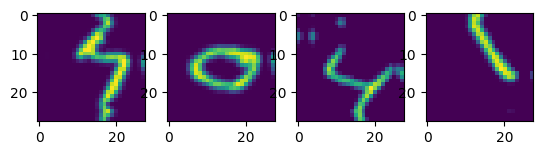

In [17]:
## the images, in the same order
fig, axs = plt.subplots(1,4)
for i in range(0,4):
    axs[i].imshow(train_images[i])
fig.show()    

In [18]:
# print(f'X:\n {X}')
# print(f'Y:\n {Y}')
print(f'Shape of data X:{X_train.shape}\n')
print(f'Shape of data Y:{Y_train.shape}\n')

Shape of data X:(60000, 28, 28, 1)

Shape of data Y:(60000,)



Les images ont comme dimensions 28x28 pixels, il y en a 60000.
1?

<BarContainer object of 10 artists>

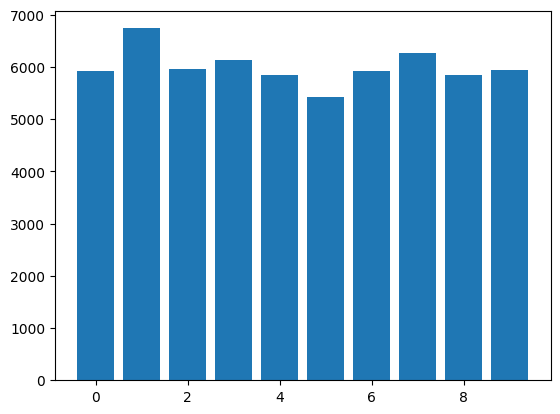

In [19]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(np.unique(Y_train), counts)

Les labels ne comportent que 10 valeurs, de 0 à 9, les chiffres contenus dans les images. 

## 3. Réaliser un premier apprentissage et une validation de la classification 

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils import plot_model

In [21]:
## Si l'accuracy n'augmente pas sur plusieurs epochs, arrêter le calcul
## Permet de mettre bcp d'epochs
callback = EarlyStopping(monitor='val_accuracy',
                         patience=8,
                         restore_best_weights=True)

In [7]:
# On transforme les valeurs en vecteur de données one-hot
Y_train_oh = to_categorical(Y_train)
Y_test_oh = to_categorical(Y_test)
print(f'Y_train shape : {Y_train.shape} ; first value = {Y_train[0]}')
print(f'Y_train_oh shape : {Y_train_oh.shape} ; first value = {Y_train_oh[0]}')

Y_train shape : (60000,) ; first value = 5
Y_train_oh shape : (60000, 10) ; first value = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


softmax
learning rate
rmsprop vs adam
categorical cross-entropy
metrics -> accuracy
add checkpoints

In [12]:
def dense1():
    model = Sequential()  # Initialisation du modèle séquentiel
    model.add(Flatten(input_shape=(28,28,1)))
    model.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    # 10 output neuron for the 10 possibles labels, the 10 classes
    model.add(Dense(units=10, activation='softmax'))

    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [13]:
model_dense = dense1()

/home/sdv/m2bi/naubourg/Documents/projet_cours_MNIST/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None


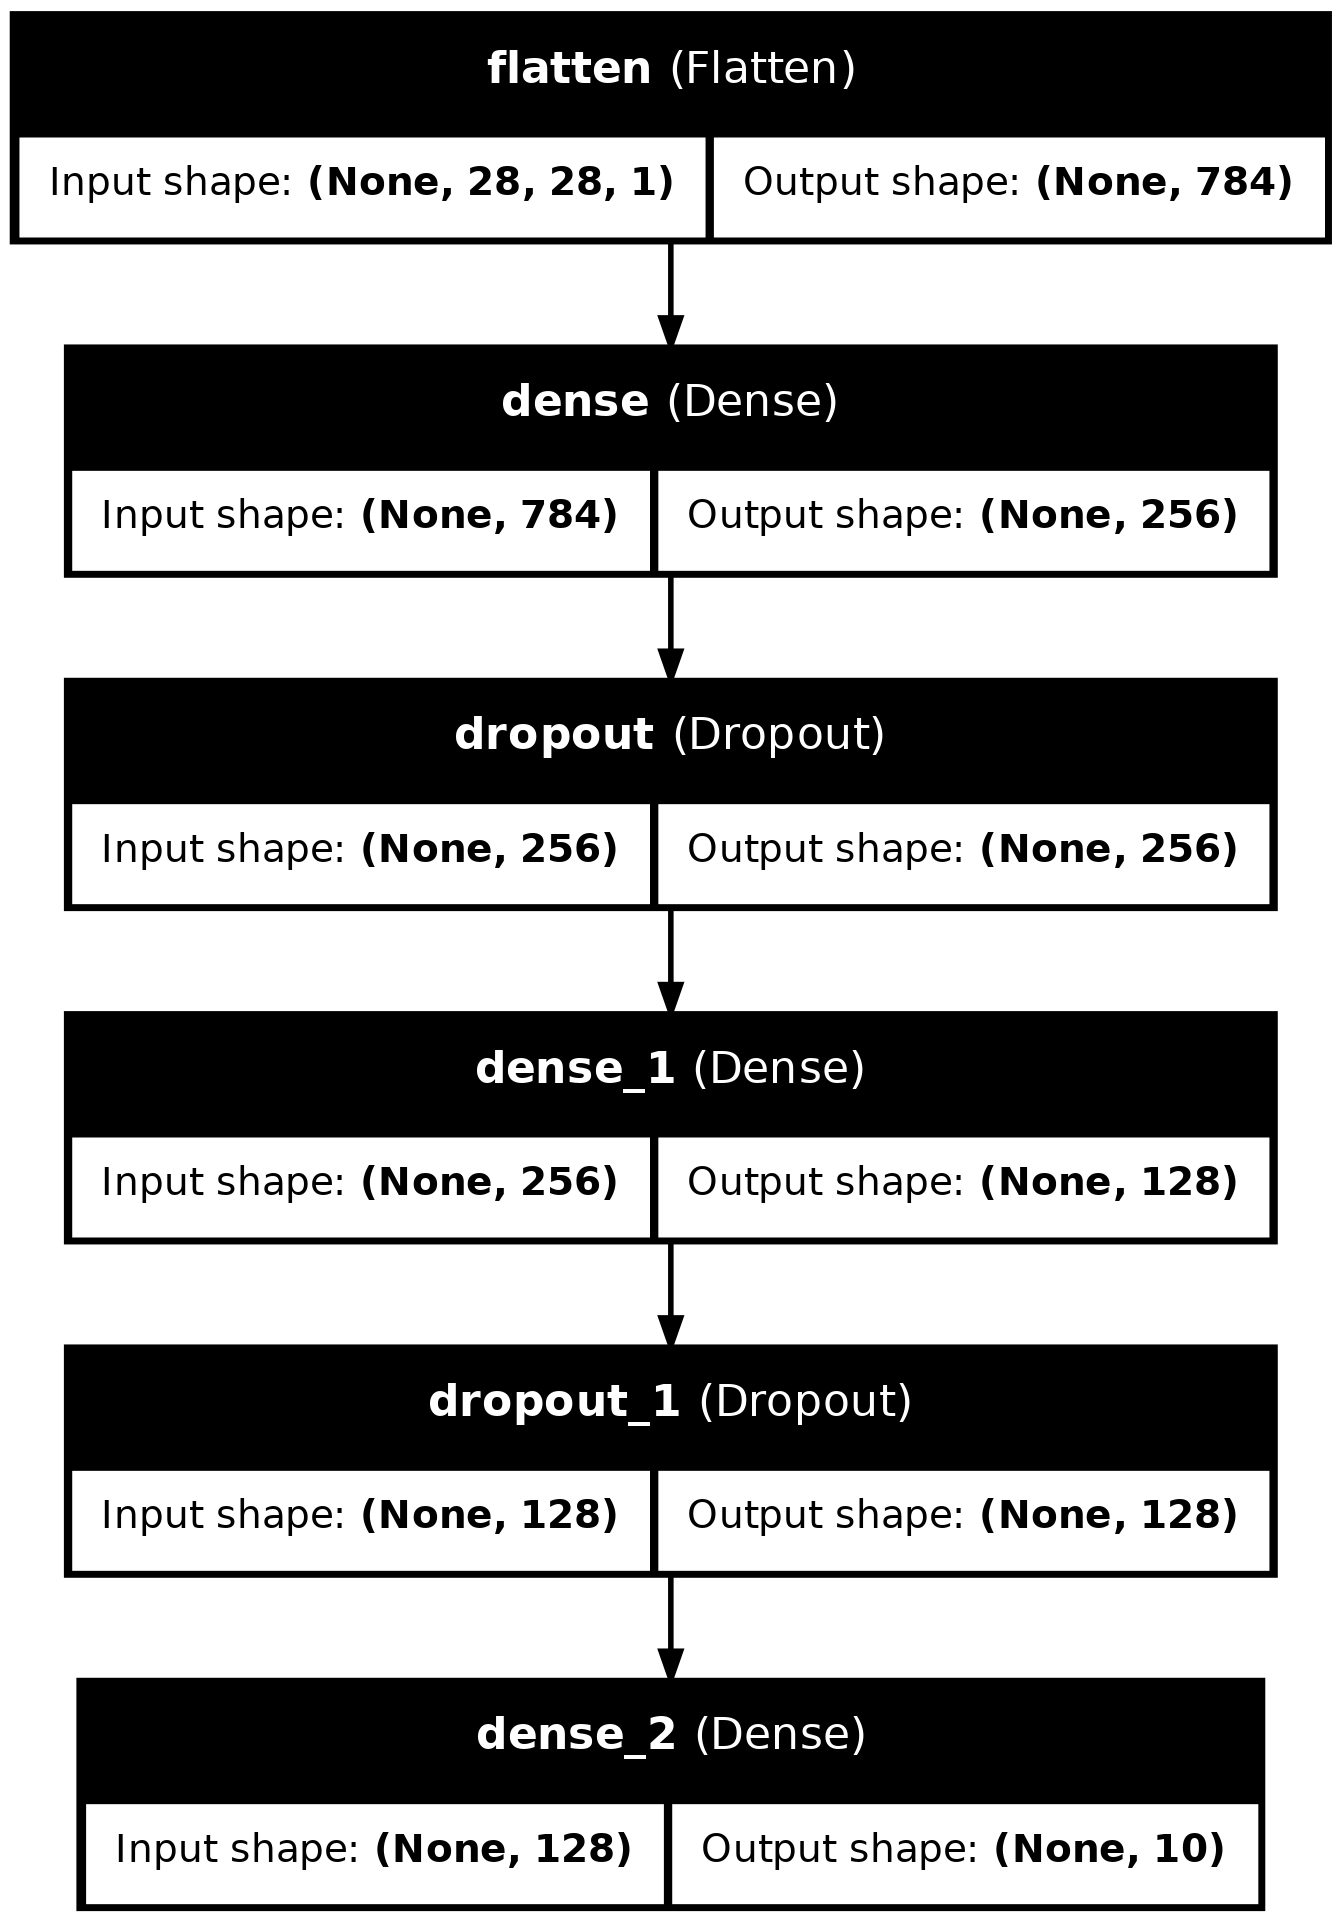

In [14]:
print(f'{model_dense.summary()}')
plot_model(model_dense, to_file="model_cnn.png",
               show_shapes=True, show_layer_names=True)

In [15]:
history_ds = model_dense.fit(X_train, 
                             Y_train_oh, 
                             validation_split=0.2, 
                             epochs=20, 
                             batch_size=50,
                             callbacks = [callback])

Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2603 - loss: 2.0471 - weighted_accuracy: 0.2603 - val_accuracy: 0.6043 - val_loss: 1.2598 - val_weighted_accuracy: 0.6043
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5320 - loss: 1.3790 - weighted_accuracy: 0.5320 - val_accuracy: 0.6704 - val_loss: 1.0132 - val_weighted_accuracy: 0.6704
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6081 - loss: 1.1834 - weighted_accuracy: 0.6081 - val_accuracy: 0.7196 - val_loss: 0.8985 - val_weighted_accuracy: 0.7196
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6431 - loss: 1.0816 - weighted_accuracy: 0.6431 - val_accuracy: 0.7421 - val_loss: 0.8175 - val_weighted_accuracy: 0.7421
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6694 - loss: 1.0144 - weighted_accuracy: 0.6694 - val_accuracy: 0.7604 - val_loss: 0.7759 - val_weighted_accuracy: 0.7604
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accura

In [ ]:
## save model
from keras.model import save_weights
model_dense.save_weights('../results/model_dense.v1')

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


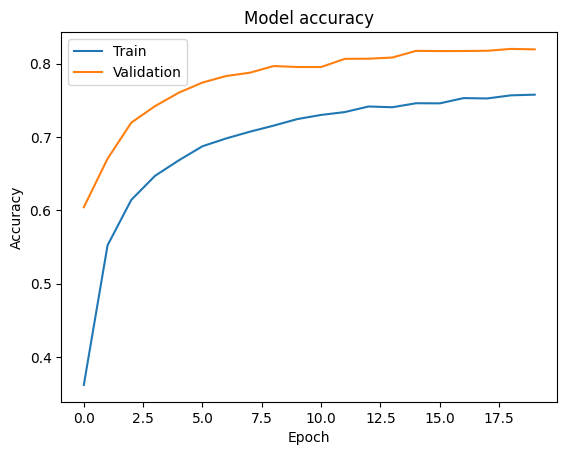

In [31]:
## plots of loss and accuracy and alternative to accuracy
print(history_ds.history.keys())
plt.plot(history_ds.history['accuracy'])
plt.plot(history_ds.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [32]:
Y_pred_oh = model_dense.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [51]:
print(Y_pred_oh.shape)
print(Y_test_oh.shape)
Y_pred_classes = np.argmax(Y_pred_oh,axis = 1)
Y_test_classes = np.argmax(Y_test_oh,axis = 1)
print(Y_pred_classes, len(Y_pred_classes))
print(Y_test_classes, len(Y_test_classes))


(10000, 10)
(10000, 10)
[7 2 1 ... 4 4 6] 10000
[7 2 1 ... 4 5 6] 10000


<Axes: >

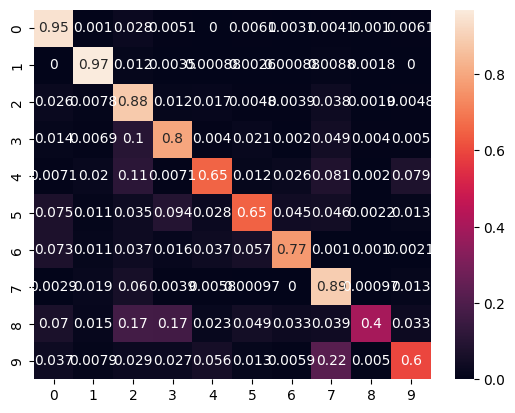

In [52]:
sns.heatmap(confusion_matrix(Y_test_classes, Y_pred_classes, normalize='true'), annot=True)

In [54]:
def cnn1():
    model = Sequential()  # Initialisation du modèle séquentiel

    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())

    model.add(Dense(10, activation='softmax'))

    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

/home/sdv/m2bi/naubourg/Documents/projet_cours_MNIST/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


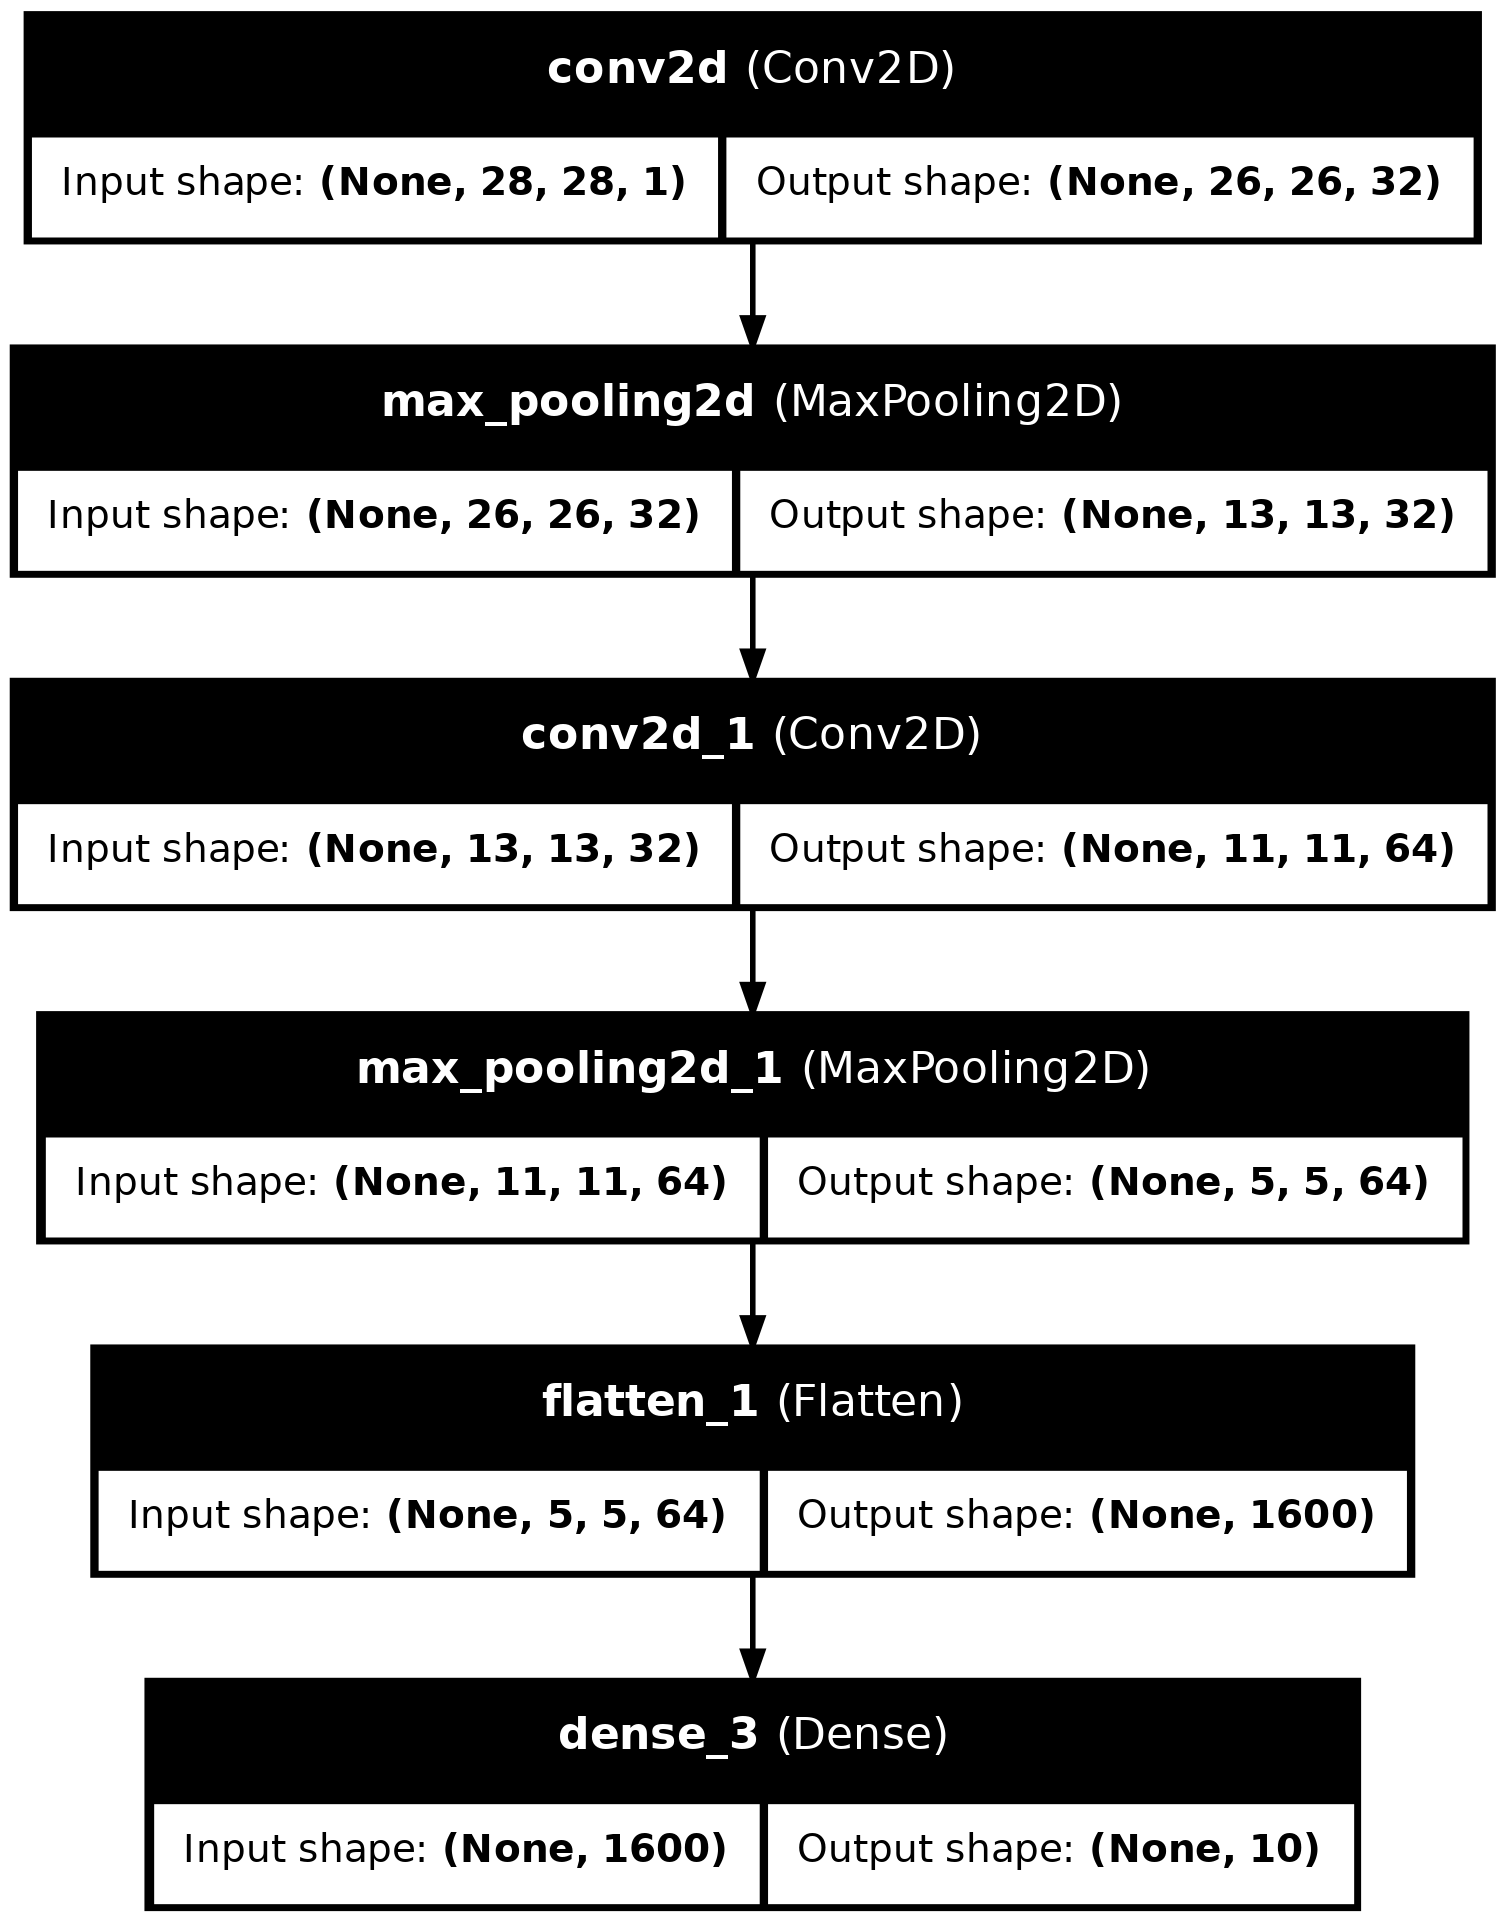

In [55]:
model_cnn = cnn1()
print(f'{model_cnn.summary()}')
plot_model(model_cnn, to_file="model_cnn.png",
               show_shapes=True, show_layer_names=True)

In [56]:
history_cnn = model_cnn.fit(X_train, 
                            Y_train_oh, 
                            validation_split=0.2, 
                            epochs=20, 
                            batch_size=50,
                            callbacks = [callback])

Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.4445 - loss: 1.6005 - weighted_accuracy: 0.4445 - val_accuracy: 0.7725 - val_loss: 0.7449 - val_weighted_accuracy: 0.7725
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.7858 - loss: 0.6924 - weighted_accuracy: 0.7858 - val_accuracy: 0.8518 - val_loss: 0.5010 - val_weighted_accuracy: 0.8518
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.8530 - loss: 0.4840 - weighted_accuracy: 0.8530 - val_accuracy: 0.8733 - val_loss: 0.4206 - val_weighted_accuracy: 0.8733
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8852 - loss: 0.3814 - weighted_accuracy: 0.8852 - val_accuracy: 0.8892 - val_loss: 0.3581 - val_weighted_accuracy: 0.8892
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9068 - loss: 0.3118 - weighted_accuracy: 0.9068 - val_accuracy: 0.8974 - val_loss: 0.3292 - val_weighted_accuracy: 0.8974
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/s

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


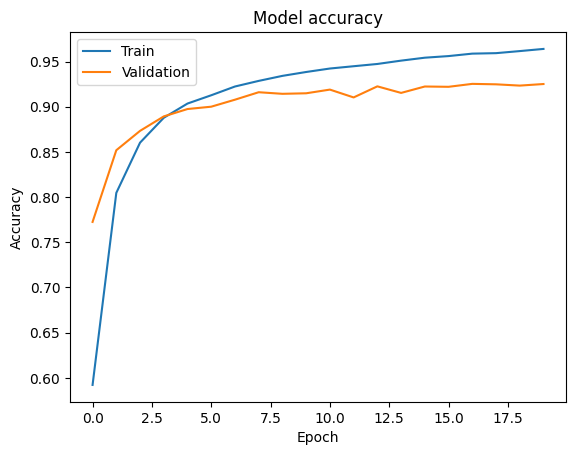

In [57]:
print(history_cnn.history.keys())
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(10000, 10)
(10000, 10)
[7 2 5 ... 4 5 6] 10000
[7 2 1 ... 4 5 6] 10000


<Axes: >

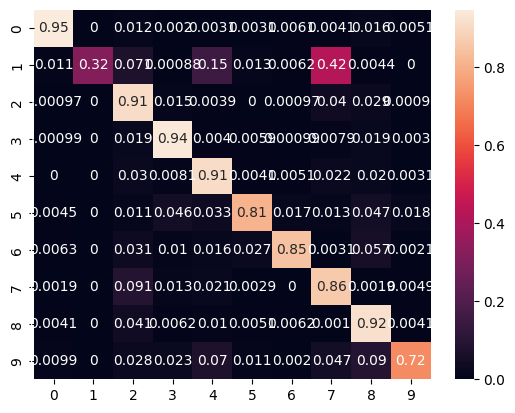

In [60]:
Y_pred_oh = model_cnn.predict(X_test)
print(Y_pred_oh.shape)
print(Y_test_oh.shape)
Y_pred_classes = np.argmax(Y_pred_oh,axis = 1)
Y_test_classes = np.argmax(Y_test_oh,axis = 1)
print(Y_pred_classes, len(Y_pred_classes))
print(Y_test_classes, len(Y_test_classes))
sns.heatmap(confusion_matrix(Y_test_classes, Y_pred_classes,
                             normalize='true'), annot=True)

## 5. Comparer la classification en faisant varier quelques paramètres

Pour le modèle en couche dense uniquement :
On peut faire varier les epochs, batchs, optimiseur, loss, nombre de neurones, l'activation des neurones. 
Il n'est pas intéressant d'ajouter des couches denses ; cela ne rendra pas le modèle tellement plus précis et il convergera moins bien. 

/home/sdv/m2bi/naubourg/Documents/projet_cours_MNIST/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2730 - loss: 2.0258 - val_accuracy: 0.5814 - val_loss: 1.2784
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5272 - loss: 1.3903 - val_accuracy: 0.6711 - val_loss: 1.0459
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6053 - loss: 1.1882 - val_accuracy: 0.7196 - val_loss: 0.9088
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6411 - loss: 1.0876 - val_accuracy: 0.7388 - val_loss: 0.8327
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6690 - loss: 1.0109 - val_accuracy: 0.7573 - val_loss: 0.7898
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6825 - loss: 0.9711 - val_accuracy: 0.7709 - val_loss: 0.7425
Epoch 7/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6996 - loss: 0.9279 - val_accuracy: 0.7773 - val_loss: 0.7269
Epoch 8/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7105 - loss: 0.9057 - val_accuracy: 0.

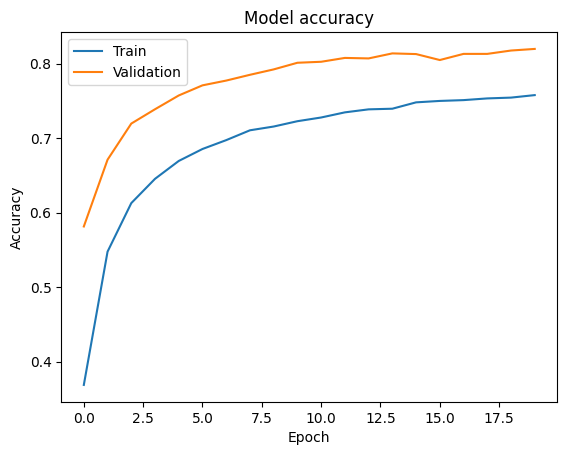

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


<Axes: >

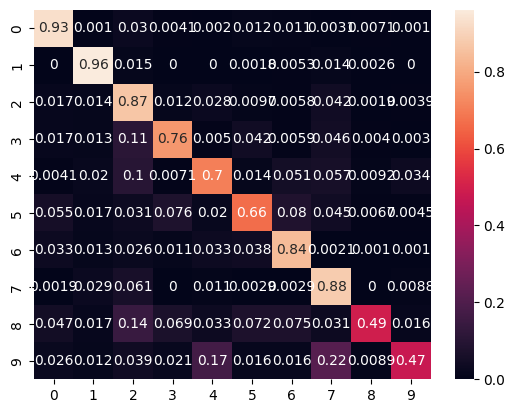

In [63]:
def dense2():
    model = Sequential() 
    model.add(Flatten(input_shape=(28,28,1)))
    model.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    # 10 output neuron for the 10 possibles labels, the 10 classes
    model.add(Dense(units=10, activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model_dense2 = dense2()
history_dense2 = model_dense2.fit(X_train, Y_train_oh, 
                                  validation_split=0.2, 
                                  epochs=20, 
                                  batch_size=50,
                                  callbacks = [callback])
print(history_dense2.history.keys())
plt.plot(history_dense2.history['accuracy'])
plt.plot(history_dense2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Y_pred_oh = model_dense2.predict(X_test)
# print(Y_pred_oh.shape)
# print(Y_test_oh.shape)
Y_pred_classes = np.argmax(Y_pred_oh,axis = 1)
# Y_test_classes = np.argmax(Y_test_oh,axis = 1)
# print(Y_pred_classes, len(Y_pred_classes))
# print(Y_test_classes, len(Y_test_classes))
sns.heatmap(confusion_matrix(Y_test_classes, Y_pred_classes,
                             normalize='true'), annot=True)

Pour le modèle en convolution, on peut ajouter une couche de neurones dense, retirer des maxpooling.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


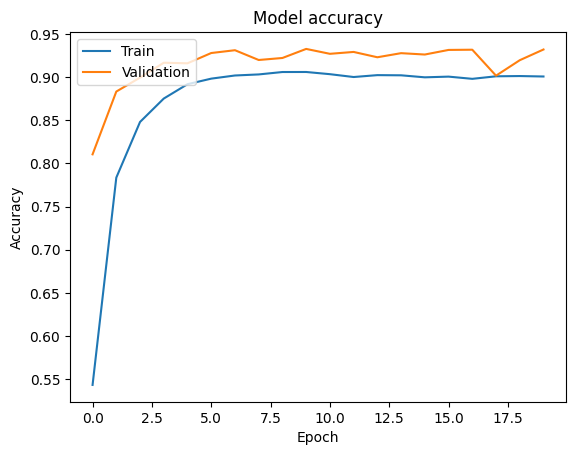

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<Axes: >

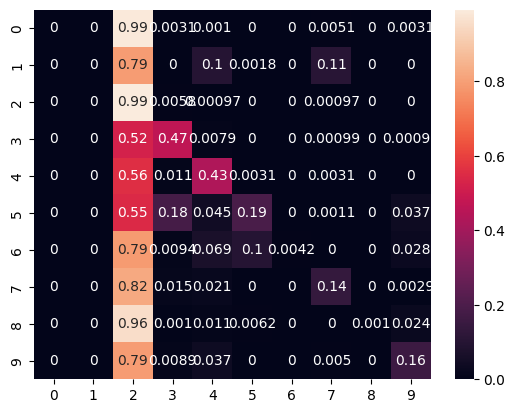

In [71]:
def cnn2():
    model = Sequential() 
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    ## Add a dense layer
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))
    # 10 output neuron for the 10 possibles labels, the 10 classes
    model.add(Dense(units=10, activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model_cnn2 = cnn2()
history_cnn2 = model_cnn2.fit(X_train, 
                              Y_train_oh, 
                              validation_split=0.2, 
                              epochs=20, 
                              batch_size=50, 
                              callbacks = [callback])
print(history_cnn2.history.keys())
plt.plot(history_cnn2.history['accuracy'])
plt.plot(history_cnn2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Y_pred_oh = model_cnn2.predict(X_test)
# print(Y_pred_oh.shape)
# print(Y_test_oh.shape)
Y_pred_classes = np.argmax(Y_pred_oh,axis = 1)
# Y_test_classes = np.argmax(Y_test_oh,axis = 1)
# print(Y_pred_classes, len(Y_pred_classes))
# print(Y_test_classes, len(Y_test_classes))
sns.heatmap(confusion_matrix(Y_test_classes, Y_pred_classes,
                             normalize='true'), annot=True)

Il y a de l'overfitting, le modèle mémorise au lieu d'apprendre. 

Retirer maxpooling

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


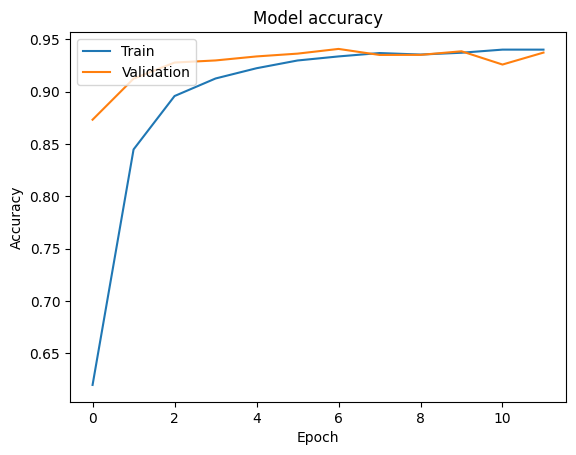

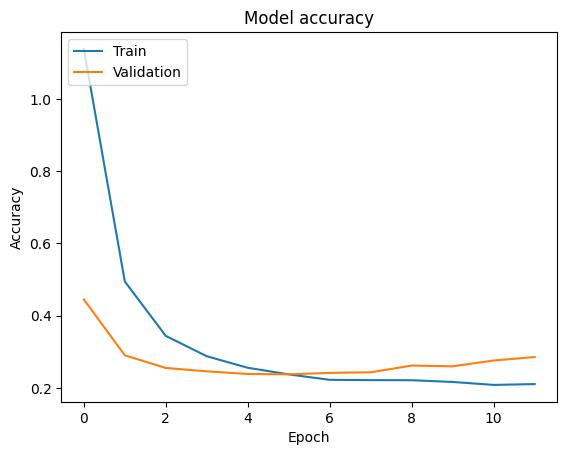

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(10000, 10)
(10000, 10)
[7 2 7 ... 2 8 2] 10000
[7 2 1 ... 4 5 6] 10000


<Axes: >

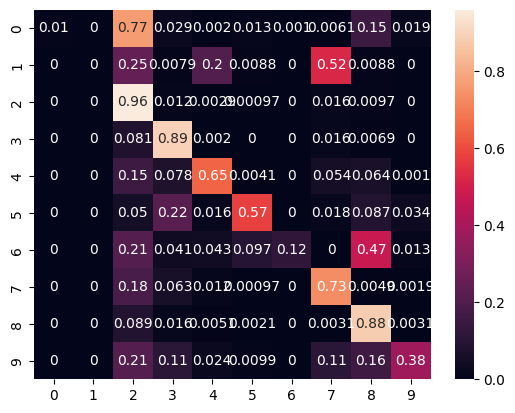

In [10]:
def cnn2():
    model = Sequential() 
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28,1)))
    # model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    ## Add a dense layer
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))
    # 10 output neuron for the 10 possibles labels, the 10 classes
    model.add(Dense(units=10, activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model_cnn2 = cnn2()
history_cnn2 = model_cnn2.fit(X_train, 
                              Y_train_oh, 
                              validation_split=0.2, 
                              epochs=20, 
                              batch_size=50, 
                              callbacks = [callback])
print(history_cnn2.history.keys())
plt.plot(history_cnn2.history['accuracy'])
plt.plot(history_cnn2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_cnn2.history['loss'])
plt.plot(history_cnn2.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Y_pred_oh = model_cnn2.predict(X_test)
print(Y_pred_oh.shape)
print(Y_test_oh.shape)
Y_pred_classes = np.argmax(Y_pred_oh,axis = 1)
Y_test_classes = np.argmax(Y_test_oh,axis = 1)
print(Y_pred_classes, len(Y_pred_classes))
print(Y_test_classes, len(Y_test_classes))
sns.heatmap(confusion_matrix(Y_test_classes, Y_pred_classes,
                             normalize='true'), annot=True)

En retirant le maxpooling, le modèle est plus lent à converger. 

En ajoutant des dropouts

Epoch 1/20


/home/sdv/m2bi/naubourg/Documents/projet_cours_MNIST/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


960/960 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.4492 - loss: 1.6095 - val_accuracy: 0.8584 - val_loss: 0.5383
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.8225 - loss: 0.5581 - val_accuracy: 0.9097 - val_loss: 0.3355
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.8795 - loss: 0.3869 - val_accuracy: 0.9270 - val_loss: 0.2808
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9008 - loss: 0.3223 - val_accuracy: 0.9268 - val_loss: 0.2826
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9127 - loss: 0.2825 - val_accuracy: 0.9299 - val_loss: 0.2404
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9205 - loss: 0.2610 - val_accuracy: 0.9350 - val_loss: 0.2377
Epoch 7/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9241 - loss: 0.2566 - val_accuracy: 0.9021 - val_loss: 0.3477
Epoch 8/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9229 - loss: 0.2566 - val_accurac

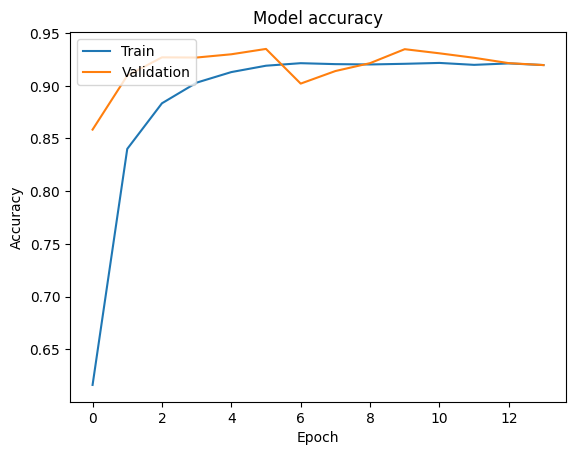

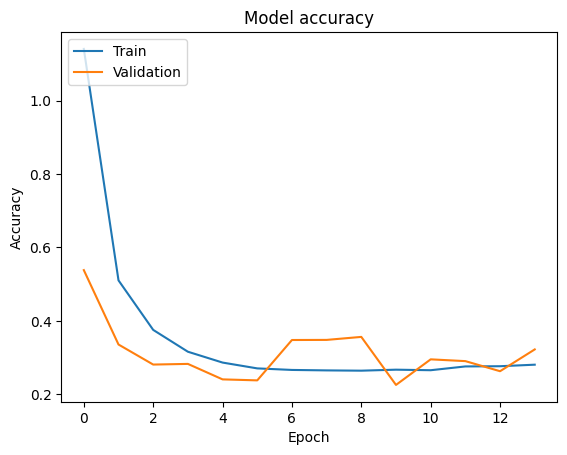

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 10)
(10000, 10)
[7 2 1 ... 4 5 6] 10000
[7 2 1 ... 4 5 6] 10000


<Axes: >

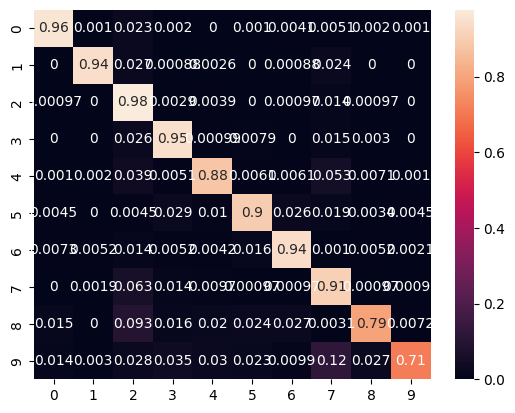

In [16]:
def cnn2():
    model = Sequential() 
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28,1)))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.3))
    model.add(Flatten())
    ## Add a dense layer
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))
    # 10 output neuron for the 10 possibles labels, the 10 classes
    model.add(Dense(units=10, activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model_cnn2 = cnn2()
history_cnn2 = model_cnn2.fit(X_train, 
                              Y_train_oh, 
                              validation_split=0.2, 
                              epochs=20, 
                              batch_size=50, 
                              callbacks = [callback])
print(history_cnn2.history.keys())
plt.plot(history_cnn2.history['accuracy'])
plt.plot(history_cnn2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_cnn2.history['loss'])
plt.plot(history_cnn2.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Y_pred_oh = model_cnn2.predict(X_test)
print(Y_pred_oh.shape)
print(Y_test_oh.shape)
Y_pred_classes = np.argmax(Y_pred_oh,axis = 1)
Y_test_classes = np.argmax(Y_test_oh,axis = 1)
print(Y_pred_classes, len(Y_pred_classes))
print(Y_test_classes, len(Y_test_classes))
sns.heatmap(confusion_matrix(Y_test_classes, Y_pred_classes,
                             normalize='true'), annot=True)

## 6. Comparer les résultats des deux approches

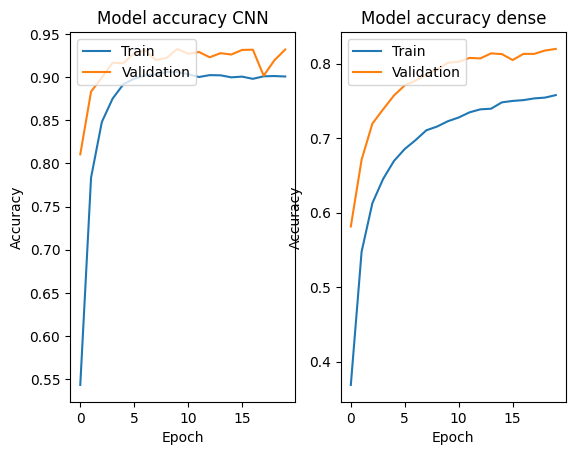

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(history_cnn2.history['accuracy'])
axes[0].plot(history_cnn2.history['val_accuracy'])
axes[0].set_title('Model accuracy CNN')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

axes[1].plot(history_dense2.history['accuracy'])
axes[1].plot(history_dense2.history['val_accuracy'])
axes[1].set_title('Model accuracy dense')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

L'usage de couches de convolution 2D rend le modèle beaucoup plus fiable. L'accuracy est plus élevé, autant pour le train que pour le test, et les prédictions sont très bonnes avec le second jeu de données.  